In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
!pip install fitter

     |████████████████████████████████| 47 kB 4.6 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25026 sha256=18d63bdccb299dba9137f91c87a4f77a1d69d433e5d21d5ebbef8bf6786aca79
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=f8cd8e1d293aa79d69b35b22076e7d1785066762db4d4581a1474c54f0ced87c
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


In [3]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
# ! pip install --upgrade Cython
# ! pip install --upgrade git+https://github.com/statsmodels/statsmodels
!pip install statsmodels --upgrade

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
  Using cached scikit_learn-1.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (24.8 MB)


In [4]:
import sys
sys.path.append('/gdrive/My Drive/extreme_pred/upload/extreme_gpd')

In [5]:
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/extreme_gpd_mlp.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/extreme_gpd_mlp3cls.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/extreme_gpd_mlp3clsMM.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/oracle_extreme_gpd_mlp3cls.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/extreme_gpd_lstm.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/extreme_gpd_ensemble.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/oracle_extreme_gpd.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/vie_extended_extreme_gpd_mlp3cls.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/mlp.py .
!cp /gdrive/My\ Drive/extreme_pred/upload/extreme_gpd/metrics.py .

In [6]:
# Required Packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import seaborn as sns
from pprint import pprint
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FormatStrFormatter

import extreme_gpd_mlp3cls
from extreme_gpd_mlp3cls import ExtremeGpd

import extreme_gpd_mlp3clsMM
from extreme_gpd_mlp3clsMM import MixtureModel

import oracle_extreme_gpd_mlp3cls
from oracle_extreme_gpd_mlp3cls import OracleExtremeGpd

import vie_extended_extreme_gpd_mlp3cls
from vie_extended_extreme_gpd_mlp3cls import vieextExtremeGpd

from mlp import MlpForecast


from metrics import Metric
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from fitter import Fitter, get_common_distributions, get_distributions

from pathlib import Path

# Load Data

In [7]:
# file_name='/gdrive/My Drive/extreme_pred/upload/Data/nasdaq100/nasdaq100/small/nasdaq100_padding.csv'
# file_name='/gdrive/My Drive/extreme_pred/upload/Data/rainfall/seattle.csv'
# file_name='/gdrive/My Drive/extreme_pred/upload/Data/rainfall/pr_1901_2020_IND.csv'
# file_name='/gdrive/My Drive/extreme_pred/upload/Data/nyc_yellow_taxi/nyc-yellow-taxi.csv'
# file_name='/gdrive/My Drive/extreme_pred/upload/Data/Metro_Interstate_Traffic_Volume/Metro_Interstate_Traffic_Volume.csv'
file_name='/gdrive/My Drive/extreme_pred/upload/Data/ETDataset/ETT-small/ETTh1.csv'
file_=Path(file_name).stem
df = pd.read_csv(file_name)
# df = pd.read_csv('/gdrive/My Drive/extreme_pred/upload/Data/nifty50/HEROMOTOCO.csv')
print(df)
print(file_)

                      date    HUFL   HULL   MUFL   MULL   LUFL   LULL  \
0      2016-07-01 00:00:00   5.827  2.009  1.599  0.462  4.203  1.340   
1      2016-07-01 01:00:00   5.693  2.076  1.492  0.426  4.142  1.371   
2      2016-07-01 02:00:00   5.157  1.741  1.279  0.355  3.777  1.218   
3      2016-07-01 03:00:00   5.090  1.942  1.279  0.391  3.807  1.279   
4      2016-07-01 04:00:00   5.358  1.942  1.492  0.462  3.868  1.279   
...                    ...     ...    ...    ...    ...    ...    ...   
17415  2018-06-26 15:00:00  -1.674  3.550 -5.615  2.132  3.472  1.523   
17416  2018-06-26 16:00:00  -5.492  4.287 -9.132  2.274  3.533  1.675   
17417  2018-06-26 17:00:00   2.813  3.818 -0.817  2.097  3.716  1.523   
17418  2018-06-26 18:00:00   9.243  3.818  5.472  2.097  3.655  1.432   
17419  2018-06-26 19:00:00  10.114  3.550  6.183  1.564  3.716  1.462   

              OT  
0      30.531000  
1      27.787001  
2      27.787001  
3      25.044001  
4      21.948000  
...      

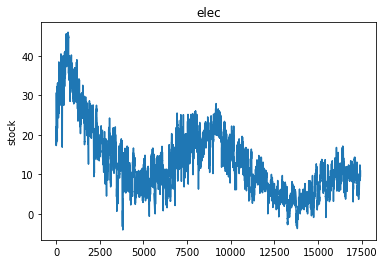

In [8]:
# time_series = df['Rainfall amount (millimetres)'].to_numpy()
# date_series = [0] * len(df)
# for index, row in df.iterrows():
    
#     date_series[index] = datetime.date(
#         int(row['Year']), int(row['Month']), int(row['Day'])
#     )
# n = time_series.shape[0]
# plt.plot(date_series, time_series)
# plt.xlabel('Date')
# plt.ylabel('Rainfall in mm')
# plt.title('Perth Rainfall Time Series')
# plt.show()


# time_series = df['PRCP'].to_numpy()
# date_series = [0] * len(df)
# for index, row in df.iterrows():
    
#     date_series[index] = datetime.datetime.strptime(
#         row['DATE'], '%Y-%m-%d'
#     )
# n = time_series.shape[0] 
# plt.plot(date_series,time_series)
# plt.xlabel('Date')
# plt.ylabel('Rainfall in mm')
# plt.title('Seattle Rainfall Time Series')
# plt.show()


# time_series = df['count'].to_numpy()    
# n = time_series.shape[0]
# # plt.plot(date_series, time_series)
# plt.plot(time_series)
# # plt.xlabel('Date')
# plt.ylabel('traffic count')
# plt.title('Nyc-taxi Time Series')
# plt.show()

# time_series = df['traffic_volume'].to_numpy()    
# n = time_series.shape[0] 
# # plt.plot(date_series, time_series)
# plt.plot(time_series)
# # plt.xlabel('Date')
# plt.ylabel('stock')
# plt.title('Metro')
# plt.show()

# time_series = df['Rainfall - (MM)'].to_numpy()    
# n = time_series.shape[0] 
# # plt.plot(date_series, time_series)
# plt.plot(time_series)
# # plt.xlabel('Date')
# plt.ylabel('Rainfall')
# plt.title('India')
# plt.show()

# time_series = df['AAPL'].to_numpy()    
# n = time_series.shape[0] 
# # plt.plot(date_series, time_series)
# plt.plot(time_series)
# # plt.xlabel('Date')
# plt.ylabel('stock')
# plt.title('AAPL')
# plt.show()

time_series = df['OT'].to_numpy()    
n = time_series.shape[0] 
# plt.plot(date_series, time_series)
plt.plot(time_series)
# plt.xlabel('Date')
plt.ylabel('stock')
plt.title('elec')
plt.show()

# time_series=[]
# with open('/gdrive/My Drive/extreme_pred/upload/Data/co2_mm_mlo.txt') as f:
#     contents_split = f.read().split()

# for i in range(20,len(contents_split),8):
#   time_series.append(float(contents_split[i]))
# time_series=np.array(time_series)

# n = time_series.shape[0]  
# plt.plot(time_series)
# plt.ylabel('stock')
# plt.title('Climate')
# plt.show()

In [9]:
print(f'Number of Missing Values: {np.isnan(time_series).sum()}')

Number of Missing Values: 0


In [10]:
# Filling Missing Values

num_prev = 5
num_next = 5

for i in np.where(np.isnan(time_series))[0]:
    values = time_series[max(i - num_prev, 0): min(i + num_next + 1, n)]
    values = values[np.logical_not(np.isnan(values))]
    
    time_series[i] = values.mean()
    
print(f'Number of Missing Values: {np.isnan(time_series).sum()}')

Number of Missing Values: 0


In [11]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(time_series)

ADF Test Statistic : -3.4879635775933884
p-value : 0.008301649485465724
#Lags Used : 44
Number of Observations : 17375
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


ADF Test Statistic : -26.330238994812238
p-value : 0.0
#Lags Used : 44
Number of Observations : 17375
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


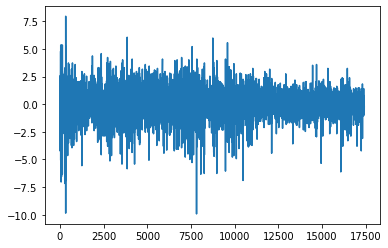

In [12]:
####first differencing

from scipy.ndimage.interpolation import shift
val_diff = time_series - shift(time_series, 1, cval=time_series[0])
# adfuller_test(val_diff.dropna())
org_time_series=time_series
time_series=val_diff[~np.isnan(val_diff)]
adfuller_test(time_series)
plt.plot(time_series)
# time_series=time_series[1:]

In [13]:
extreme_rthreshold = np.quantile(time_series,.98)
print(extreme_rthreshold)
extreme_lthreshold = np.quantile(time_series,.02)
# extreme_lthreshold = -3.0
print(extreme_lthreshold)
# extreme_threshold=20

2.039999961853029
-2.1100006103515625


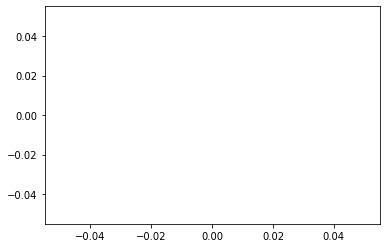

In [14]:
maxim=(max(time_series))
thresh=250
res_time=[]
for i in np.arange(thresh,maxim):
  res_time.append(np.mean(time_series[time_series>i]-i))

plt.scatter(np.arange(thresh,maxim),res_time)
plt.show()

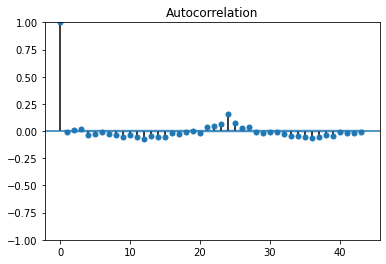

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


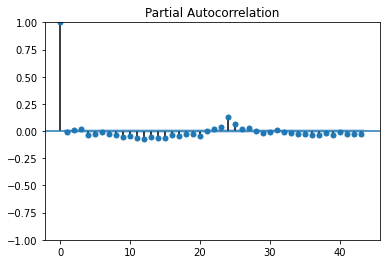

In [15]:
plot_acf(time_series)
plt.show()
plot_pacf(time_series)
plt.show()

In [16]:
values = [e for e in time_series if (e>extreme_lthreshold and e<extreme_rthreshold)]

In [17]:
# from scipy.stats import norm
# import statistics

# mean = statistics.mean(time_series)
# sd = statistics.stdev(time_series)
  
# plt.plot(np.sort(time_series), norm.pdf(np.sort(time_series), mean, sd))
# # plt.show()

# plt.hist(time_series, bins=50, density=True)
# plt.show()

# f = Fitter(time_series,
#            distributions=get_common_distributions())
# f.fit()
# f.summary()

# f.get_best(method = 'sumsquare_error')

In [18]:
# decompose_result = seasonal_decompose(time_series, model="additive",period=1) # additive trend
# decompose_result.plot()
# plt.show()

# Train-Val-Test Split

In [19]:
train_frac = 0.80
val_frac = 0.10

num_train = int(n * train_frac)
num_val = int(n * val_frac)
num_test = n - num_train - num_val

print(f'Num Train: {num_train}, Num Val: {num_val}, Num Test: {num_test}')

Num Train: 13936, Num Val: 1742, Num Test: 1742


In [20]:
train_test_ranges = []
tscv = TimeSeriesSplit(n_splits=3, test_size=num_test)
for train_index, test_index in tscv.split(time_series):
    train_test_ranges.append(((train_index[0], train_index[-1]), (test_index[0], test_index[-1])))
print('Train-Test Ranges:')
pprint(train_test_ranges)

Train-Test Ranges:
[((0, 12193), (12194, 13935)),
 ((0, 13935), (13936, 15677)),
 ((0, 15677), (15678, 17419))]


In [21]:
# train_size = num_train
# test_size = int(num_test / 1.5)
# num_runs = 2

# window_increment = int((num_test - test_size) / (num_runs - 1))

# print(f'Train Size: {train_size}, Test Size: {test_size}, '
#       + f'Num Runs: {num_runs}, Window Increment: {window_increment} ')

# train_test_ranges = []
# test_idx_low = num_train

# while test_idx_low + test_size <= n:
#     test_idx_high = test_idx_low + test_size
    
#     train_idx_high = test_idx_low
#     train_idx_low = train_idx_high - train_size
    
#     train_test_ranges.append(((train_idx_low, train_idx_high), (test_idx_low, test_idx_high)))
    
#     test_idx_low += window_increment

# print('Train-Test Ranges:')
# pprint(train_test_ranges)

# Helpers

In [32]:
def calculate_and_display_metrics(
    train_pred_output, train_true_output,
    val_test_pred_output, val_test_true_output,
    val_or_test='Val'
):
    
    # Train
    train_rmse = Metric.rmse(
        train_pred_output, train_true_output
    )

    train_mae = Metric.mae(train_pred_output, train_true_output)
    train_smape = Metric.smape(train_pred_output, train_true_output)

    if np.all(train_true_output<extreme_rthreshold) and np.all(train_true_output>extreme_lthreshold):
      train_extreme_rmse=0
      train_extreme_mae=0
      train_extreme_smape=0
    else:
      train_extreme_rmse = Metric.errorOnExtremes(
          train_pred_output, train_true_output, extreme_lthreshold, extreme_rthreshold,
          Metric.rmse
      )

    
      train_extreme_mae = Metric.errorOnExtremes(
          train_pred_output, train_true_output,extreme_lthreshold, extreme_rthreshold,
          Metric.mae
      )

    
      train_extreme_smape = Metric.errorOnExtremes(
          train_pred_output, train_true_output, extreme_lthreshold, extreme_rthreshold,
          Metric.smape
      )
    

    print(f'Train: RMSE: {train_rmse}, Extreme RMSE: {train_extreme_rmse}, '
         + f'MAE: {train_mae}, Extreme MAE: {train_extreme_mae}'
         + f'SMAPE: {train_smape}, Extreme SMAPE: {train_extreme_smape}')
    
    # # Validation
    val_test_rmse = Metric.rmse(
        val_test_pred_output, val_test_true_output
    )
    val_test_mae = Metric.mae(val_test_pred_output, val_test_true_output)
    val_test_smape = Metric.smape(val_test_pred_output, val_test_true_output)

    if np.all(val_test_true_output<extreme_rthreshold) and np.all(val_test_true_output>extreme_lthreshold):
      val_test_extreme_rmse=0
      val_test_extreme_mae=0
      val_test_extreme_smape=0
    else:
      val_test_extreme_rmse = Metric.errorOnExtremes(
          val_test_pred_output, val_test_true_output,extreme_lthreshold, extreme_rthreshold,
          Metric.rmse
      )
      
      val_test_extreme_mae = Metric.errorOnExtremes(
          val_test_pred_output, val_test_true_output,extreme_lthreshold, extreme_rthreshold,
          Metric.mae
      )

      val_test_extreme_smape = Metric.errorOnExtremes(
          val_test_pred_output, val_test_true_output,extreme_lthreshold, extreme_rthreshold,
          Metric.smape
      )

    print(f'{val_or_test}: RMSE: {val_test_rmse}, Extreme RMSE: {val_test_extreme_rmse}, '
         + f'MAE: {val_test_mae}, Extreme MAE: {val_test_extreme_mae}, '
         + f'SMAPE: {val_test_smape}, Extreme SMAPE: {val_test_extreme_smape}')
    
    return {
        'train': {
            'rmse': train_rmse,
            'extreme_rmse': train_extreme_rmse,
            'mae': train_mae,
            'extreme_mae': train_extreme_mae,
            'smape': train_smape,
            'extreme_smape': train_extreme_smape
        },
        val_or_test: {
            'rmse': val_test_rmse,
            'extreme_rmse': val_test_extreme_rmse,
            'mae': val_test_mae,
            'extreme_mae': val_test_extreme_mae,
            'smape': val_test_smape,
            'extreme_smape': val_test_extreme_smape
        }
    }

def compute_stat(result_list):
    
    metric_names = list(result_list[0]['train'].keys())
    
    for train_or_test in ['train', 'Test']:
        print(train_or_test)
        
        for metric in metric_names:
            metric_values = np.array([
                result_element[train_or_test][metric]
                for result_element in result_list
            ])
            
            print(f'{metric}: Mean: {metric_values.mean():.2f}, Std Dev: {metric_values.std():.2f}, '
                 + f'Min: {metric_values.min():.2f}, Max: {metric_values.max():.2f}')
    
    train_times = np.array([
        result_element['train_time']
        for result_element in result_list
    ])
    print(f'train time: Mean: {train_times.mean():.2f}, Std Dev: {train_times.std():.2f}, '
        + f'Min: {train_times.min():.2f}, Max: {train_times.max():.2f}')
    
    pred_times = np.array([
        result_element['pred_time']
        for result_element in result_list
    ])
    print(f'pred time: Mean: {pred_times.mean():.2f}, Std Dev: {pred_times.std():.2f}, '
        + f'Min: {pred_times.min():.2f}, Max: {pred_times.max():.2f}')
    
    
def plot_confusion_matrix(y_true, y_pred):
    
    assert y_true.shape == y_pred.shape
    n = y_true.shape[0]
    
    confusion_matrix = np.zeros((3, 3))
    
    for i in range(n):
        confusion_matrix[y_true[i]][y_pred[i]] += 1
        
    confusion_matrix_df = pd.DataFrame(
        confusion_matrix,
        index=[0, 1, 2],
        columns=[0, 1, 2]
    )
    
    plt.figure(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix_df, annot=True,fmt='g')
    sns.set(font_scale=1.4)
    plt.show()

In [23]:
# lower_bound = extreme_threshold

# bounded_count = dict()

# for value in time_series:
    
#     if value <= lower_bound:
#         continue
    
#     if value not in bounded_count:
#         bounded_count[value] = 1
#     else:
#         bounded_count[value] += 1
        
# value_count = list(bounded_count.items())
# value_count.sort(key=lambda count: count[0])
# value_arr, count_arr = list(zip(*value_count))
# count_cusum_rev = [0] * len(count_arr)

# count_cusum_rev[-1] = count_arr[-1]
# for i in range(len(count_cusum_rev) - 2, -1, -1):
#     count_cusum_rev[i] = count_cusum_rev[i + 1] + count_arr[i]

# plt.figure(figsize=(16, 8))
# plt.plot(value_arr, count_cusum_rev)
# plt.xlabel('Values')
# plt.ylabel('Number of Values with equal or higher value')
# plt.title('Complementary Cumulative Plot')
# plt.show()

In [24]:
# Train
gpdParamRanges = [(-10, 10), (1, 30)]
numPsoParticles = 250
numPsoIterations = 200
numExtremeIterations = 150
numNormalIterations = 150
numClassifierIterations = 150
numIterations=150

# Extreme_gpd

In [25]:
# # def try_param(
#     # threshold, lag, numModelsEnsemble, negPosDataRatio
# # ):

# def try_param(
#     threshold, lag
# ):
    
# # def try_param(
# #     threshold, lag, extreme_weight, evl_weight,
# #     train_low, train_high, test_low, test_high
# # ):
    
#     test_results = []

#     for (train_low, train_high), (test_low, test_high) in train_test_ranges:

#         print(f'Train: {train_low}: {train_high}, Test: {test_low}: {test_high}')

#         try_again = True
#         while try_again:
#             print('try')

#             # extreme_gpd = ExtremeGpd(threshold, lag, numModelsEnsemble, negPosDataRatio)
#             extreme_gpd = ExtremeGpd(threshold, lag) #one classifier 
#             train_time = time.time()

#             trainSummary = extreme_gpd.train(
#                 time_series[train_low: train_high],
#                 gpdParamRanges,
#                 numPsoParticles,
#                 numPsoIterations,
#                 numExtremeIterations,
#                 numNormalIterations,
#                 numClassifierIterations
#             )

#             train_time = time.time() - train_time

#             pred_time = time.time()

#             input_data = time_series[train_low: test_high-1]
#             true_output = time_series[train_low + lag: test_high]
#             # pred_output = extreme_gpd.predict(input_data)
#             pred_output, extremeProb, predNormal, predLExtreme, predRExtreme = extreme_gpd.predict(input_data,True)
#             pred_time = time.time() - pred_time

#             try_again = np.sum(np.logical_or(np.isnan(pred_output), np.isinf(pred_output))) > 0

            
#             plt.plot(true_output,label="true") 
#             plt.plot(pred_output,label="pred")
#             plt.plot(np.ones(len(true_output))*threshold[0])
#             plt.plot(np.ones(len(true_output))*threshold[1])
#             plt.legend()
#             plt.show()

#         print(f'Train Time: {train_time}, Pred Time: {pred_time}')

#         num_train_out = train_high - train_low - lag
# # ##################
#         fin_true_output=np.cumsum(true_output)
#         #fin_true_output=true_output + shift(org_time_series[train_low + lag: test_high], 1, cval=org_time_series[lag-1]) # for differenced
#         fin_pred_output=np.cumsum(pred_output)
# ###############

#         result_dict = calculate_and_display_metrics(
#             pred_output[:num_train_out], true_output[:num_train_out],
#             pred_output[num_train_out:], true_output[num_train_out:],
#             'Test'
#         )

#         result_dict['train_time'] = train_time
#         result_dict['pred_time'] = pred_time

#         test_results.append(result_dict)

#         print('------------------------------------------\n')
#         true_lab=np.array([0 if (i<extreme_rthreshold and i>extreme_lthreshold) else 1 if (i>=extreme_rthreshold) else 2 if (i<=extreme_lthreshold) else 3 for i in true_output])
#         pred_lab=np.array(np.argmax(extremeProb,axis=1),dtype=int)
#         plot_confusion_matrix(true_lab[test_low:test_high],pred_lab[test_low:test_high])

#     true_lab=np.array([0 if (i<extreme_rthreshold and i>extreme_lthreshold) else 1 if (i>=extreme_rthreshold) else 2 if (i<=extreme_lthreshold) else 3 for i in true_output])
#     pred_lab=np.array(np.argmax(extremeProb,axis=1),dtype=int)
#     colormap = np.array(['y', 'r', 'g'])
#     plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output],label="diff",s=10,c=colormap[true_lab])
#     plt.show()
#     plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output]/np.multiply((np.abs(true_output)+np.abs(pred_output)),0.5),label="diff",s=10,c=colormap[true_lab])
#     # plt.scatter(np.arange(0,len(true_output)),[fin_true_output-fin_pred_output],label="diff",s=10,c=colormap[true_lab]) #diff##########
#     plt.show()
#     plt.plot(true_output[-150:-1],label="true") 
#     plt.plot(pred_output[-150:-1],label="pred")
#     plt.legend()
#     plt.show()
#     plt.plot(fin_true_output,label="true") #diff#################
#     plt.plot(fin_pred_output,label="pred")
#     plt.legend()
#     plt.show() 
   
#     plot_confusion_matrix(true_lab,pred_lab)
#     compute_stat(test_results)
#     return trainSummary

MixtureModel

In [26]:
# # def try_param(
#     # threshold, lag, numModelsEnsemble, negPosDataRatio
# # ):

# def try_param(
#     threshold, lag
# ):
    
# # def try_param(
# #     threshold, lag, extreme_weight, evl_weight,
# #     train_low, train_high, test_low, test_high
# # ):
    
#     test_results = []

#     for (train_low, train_high), (test_low, test_high) in train_test_ranges:

#         print(f'Train: {train_low}: {train_high}, Test: {test_low}: {test_high}')

#         try_again = True
#         while try_again:
#             print('try')

#             # extreme_gpd = ExtremeGpd(threshold, lag, numModelsEnsemble, negPosDataRatio)
#             mm = MixtureModel(threshold, lag) #one classifier 
#             train_time = time.time()

#             trainSummary = mm.train(
#                 time_series[train_low: train_high],
#                 gpdParamRanges,
#                 numPsoParticles,
#                 numPsoIterations,
#                 numIterations,
#                 max_iter=3
#             )

#             plt.plot(trainSummary['loss'])
#             plt.show()

#             train_time = time.time() - train_time

#             pred_time = time.time()

#             input_data = time_series[train_low: test_high-1]
#             true_output = time_series[train_low + lag: test_high]
#             # pred_output = extreme_gpd.predict(input_data)
#             pred_output, predNormal, predLExtreme, predRExtreme = mm.predict(input_data,True)
#             plt.plot(predNormal)
#             plt.show()
#             plt.plot(predLExtreme)
#             plt.show()
#             pred_time = time.time() - pred_time

#             try_again = np.sum(np.logical_or(np.isnan(pred_output), np.isinf(pred_output))) > 0

            
#             plt.plot(true_output,label="true") 
#             plt.plot(pred_output,label="pred")
#             plt.plot(np.ones(len(true_output))*threshold[0])
#             plt.plot(np.ones(len(true_output))*threshold[1])
#             plt.legend()
#             plt.show()

#         print(f'Train Time: {train_time}, Pred Time: {pred_time}')

#         num_train_out = train_high - train_low - lag
# # ##################
#         fin_true_output=np.cumsum(true_output)
#         #fin_true_output=true_output + shift(org_time_series[train_low + lag: test_high], 1, cval=org_time_series[lag-1]) # for differenced
#         fin_pred_output=np.cumsum(pred_output)
# ###############

#         result_dict = calculate_and_display_metrics(
#             pred_output[:num_train_out], true_output[:num_train_out],
#             pred_output[num_train_out:], true_output[num_train_out:],
#             'Test'
#         )

#         result_dict['train_time'] = train_time
#         result_dict['pred_time'] = pred_time

#         test_results.append(result_dict)

#         print('------------------------------------------\n')
#         # true_lab=np.array([0 if (i<extreme_rthreshold and i>extreme_lthreshold) else 1 if (i>=extreme_rthreshold) else 2 if (i<=extreme_lthreshold) else 3 for i in true_output])
#         # pred_lab=np.array(np.argmax(extremeProb,axis=1),dtype=int)
#         # plot_confusion_matrix(true_lab[test_low:test_high],pred_lab[test_low:test_high])

#     true_lab=np.array([0 if (i<extreme_rthreshold and i>extreme_lthreshold) else 1 if (i>=extreme_rthreshold) else 2 if (i<=extreme_lthreshold) else 3 for i in true_output])
#     # pred_lab=np.array(np.argmax(extremeProb,axis=1),dtype=int)
#     colormap = np.array(['y', 'r', 'g'])
#     plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output],label="diff",s=10,c=colormap[true_lab])
#     plt.show()
#     plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output]/np.multiply((np.abs(true_output)+np.abs(pred_output)),0.5),label="diff",s=10,c=colormap[true_lab])
#     # plt.scatter(np.arange(0,len(true_output)),[fin_true_output-fin_pred_output],label="diff",s=10,c=colormap[true_lab]) #diff##########
#     plt.show()
#     plt.plot(true_output[-150:-1],label="true") 
#     plt.plot(pred_output[-150:-1],label="pred")
#     plt.legend()
#     plt.show()
#     plt.plot(fin_true_output,label="true") #diff#################
#     plt.plot(fin_pred_output,label="pred")
#     plt.legend()
#     plt.show() 
   
#     # plot_confusion_matrix(true_lab,pred_lab)
#     compute_stat(test_results)
#     return trainSummary

**VIE_extended**

In [27]:
# def try_param(
    # threshold, lag, numModelsEnsemble, negPosDataRatio
# ):

def try_param(
    threshold, lag
):
    
# def try_param(
#     threshold, lag, extreme_weight, evl_weight,
#     train_low, train_high, test_low, test_high
# ):
    
    print(train_test_ranges)
    test_results = []
    colormap = np.array(['y', 'r', 'g'])
    run_count = 0 

    for (train_low, train_high), (test_low, test_high) in train_test_ranges:

        print(f'Train: {train_low}: {train_high}, Test: {test_low}: {test_high}')

        try_again = True
        while try_again:
            print('try')

            vieextextreme_gpd = vieextExtremeGpd(threshold, lag) #one classifier 
            train_time = time.time()

            trainSummary = vieextextreme_gpd.train(
                time_series[train_low: train_high],
                gpdParamRanges,
                numPsoParticles,
                numPsoIterations,
                numExtremeIterations,
                numNormalIterations
            )

            train_time = time.time() - train_time

            pred_time = time.time()

          
            true_output = time_series[train_low + lag: test_high]

            pred_output, predNormal, predLExtreme, predRExtreme = vieextextreme_gpd.predict(time_series, train_low, test_high, run_count, file_, True)
            pred_time = time.time() - pred_time

            try_again = np.sum(np.logical_or(np.isnan(pred_output), np.isinf(pred_output))) > 0
            num_train_out = train_high - train_low - lag
            
            true_lab=np.array([0 if (i<extreme_rthreshold and i>extreme_lthreshold) else 1 if (i>=extreme_rthreshold) else 2 if (i<=extreme_lthreshold) else 3 for i in true_output])
            plt.plot(true_output[num_train_out:],label="true") 
            plt.plot(pred_output[num_train_out:],label="pred")
            plt.plot((np.ones(len(true_output))*threshold[0])[num_train_out:])
            plt.plot((np.ones(len(true_output))*threshold[1])[num_train_out:])
            plt.legend()
            plt.scatter(np.arange(0,len(true_output[num_train_out:])),[true_output[num_train_out:]-pred_output[num_train_out:]],label="diff",s=10,c=colormap[true_lab[num_train_out:]]) #diff##########
            # plt.show()
            plt.show()

        run_count+=1
        print(f'Train Time: {train_time}, Pred Time: {pred_time}')

        
# ##################
        fin_true_output=np.cumsum(true_output)
        #fin_true_output=true_output + shift(org_time_series[train_low + lag: test_high], 1, cval=org_time_series[lag-1]) # for differenced
        fin_pred_output=np.cumsum(pred_output)
###############

        result_dict = calculate_and_display_metrics(
            pred_output[:num_train_out], true_output[:num_train_out],
            pred_output[num_train_out:], true_output[num_train_out:],
            'Test'
        )

        result_dict['train_time'] = train_time
        result_dict['pred_time'] = pred_time

        test_results.append(result_dict)

        print('------------------------------------------\n')
        

    
    plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output],label="diff",s=10,c=colormap[true_lab])
    plt.show()
    # plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output]/np.multiply((np.abs(true_output)+np.abs(pred_output)),0.5),label="diff",s=10,c=colormap[true_lab])
    
    plt.plot(true_output[num_train_out+1600:num_train_out+2100],label="true") 
    plt.plot(pred_output[num_train_out+1600:num_train_out+2100],label="pred")
    plt.legend()
    plt.show()
    # plt.hist(true_output, bins=50,  fc=(0, 0, 1, 0.5))
    # plt.hist(pred_output, bins=50,  fc=(1, 0, 0, 0.5))
    # plt.show()

    maskArr = np.logical_or(true_output[num_train_out:] >= extreme_rthreshold, true_output[num_train_out:] <= extreme_lthreshold)
    true_op=true_output[num_train_out:]
    pred_op=pred_output[num_train_out:]
    plt.hist(true_op[maskArr]-pred_op[maskArr], bins=50,  fc=(0, 0, 1, 0.5))
    plt.show()

    plt.plot(fin_true_output,label="true") #diff#################
    plt.plot(fin_pred_output,label="pred")
    plt.legend()
    plt.show() 
   
    compute_stat(test_results)
    return trainSummary

In [28]:
# trainSummary = try_param(
#     extreme_threshold, 50 , 10, 1.5
# )

trainSummary = try_param(
    [extreme_lthreshold,extreme_rthreshold] , 9
)

# trainSummary = try_param(
#     extreme_threshold, 50, extreme_weight, evl_weight, 0, 
#     num_train, num_train, num_train + num_val
# )

# plt.plot(trainSummary['loss-normal'], label='normal')
# plt.show()
# plt.plot(trainSummary['loss-classifier'], label='evl')
# plt.legend()
# plt.title('Classifier')
# plt.show()
# plt.plot(trainSummary['gpd-convergence'][0], label='gpd')
# plt.show()
# plt.plot(trainSummary['loss-extreme'][0], label='extreme')
# plt.show()

[((0, 12193), (12194, 13935)), ((0, 13935), (13936, 15677)), ((0, 15677), (15678, 17419))]
Train: 0: 12193, Test: 12194: 13935
try


KeyboardInterrupt: ignored

## Oracle_extreme_gpd

In [29]:
# Train
gpdParamRanges = [(-10, 10), (1, 30)]
numPsoParticles = 250
numPsoIterations = 200
numExtremeIterations = 150
numNormalIterations = 200
numClassifierIterations = 150
numIterations=150

In [30]:
# def try_param(
    # threshold, lag, numModelsEnsemble, negPosDataRatio
# ):

def try_param(
    threshold, lag
):
    
# def try_param(
#     threshold, lag, extreme_weight, evl_weight,
#     train_low, train_high, test_low, test_high
# ):
    
    print(train_test_ranges)
    test_results = []
    colormap = np.array(['y', 'r', 'g'])

    for (train_low, train_high), (test_low, test_high) in train_test_ranges:

        print(f'Train: {train_low}: {train_high}, Test: {test_low}: {test_high}')

        try_again = True
        while try_again:
            print('try')

            oracleextreme_gpd = OracleExtremeGpd(threshold, lag) #one classifier 
            train_time = time.time()

            trainSummary = oracleextreme_gpd.train(
                time_series[train_low: train_high],
                gpdParamRanges,
                numPsoParticles,
                numPsoIterations,
                numExtremeIterations,
                numNormalIterations
            )

            train_time = time.time() - train_time

            pred_time = time.time()

            input_data = time_series[train_low: test_high+1]
            true_output = time_series[train_low + lag: test_high+1]

            pred_output, predNormal, predLExtreme, predRExtreme = oracleextreme_gpd.predict(input_data,True)
            pred_time = time.time() - pred_time

            try_again = np.sum(np.logical_or(np.isnan(pred_output), np.isinf(pred_output))) > 0
            num_train_out = train_high - train_low - lag
            
            true_lab=np.array([0 if (i<extreme_rthreshold and i>extreme_lthreshold) else 1 if (i>=extreme_rthreshold) else 2 if (i<=extreme_lthreshold) else 3 for i in true_output])
            plt.plot(true_output[num_train_out:],label="true") 
            plt.plot(pred_output[num_train_out:],label="pred")
            plt.plot((np.ones(len(true_output))*threshold[0])[num_train_out:])
            plt.plot((np.ones(len(true_output))*threshold[1])[num_train_out:])
            plt.legend()
            plt.scatter(np.arange(0,len(true_output[num_train_out:])),[true_output[num_train_out:]-pred_output[num_train_out:]],label="diff",s=10,c=colormap[true_lab[num_train_out:]]) #diff##########
            # plt.show()
            plt.show()
        print(f'Train Time: {train_time}, Pred Time: {pred_time}')

        
# ##################
        fin_true_output=np.cumsum(true_output)
        #fin_true_output=true_output + shift(org_time_series[train_low + lag: test_high], 1, cval=org_time_series[lag-1]) # for differenced
        fin_pred_output=np.cumsum(pred_output)
###############

        result_dict = calculate_and_display_metrics(
            pred_output[:num_train_out], true_output[:num_train_out],
            pred_output[num_train_out:], true_output[num_train_out:],
            'Test'
        )

        result_dict['train_time'] = train_time
        result_dict['pred_time'] = pred_time

        test_results.append(result_dict)

        print('------------------------------------------\n')
        

    
    plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output],label="diff",s=10,c=colormap[true_lab])
    plt.show()
    # plt.scatter(np.arange(0,len(true_output)),[true_output-pred_output]/np.multiply((np.abs(true_output)+np.abs(pred_output)),0.5),label="diff",s=10,c=colormap[true_lab])
    
    plt.plot(true_output[num_train_out+1600:num_train_out+2100],label="true") 
    plt.plot(pred_output[num_train_out+1600:num_train_out+2100],label="pred")
    plt.legend()
    plt.show()
    # plt.hist(true_output, bins=50,  fc=(0, 0, 1, 0.5))
    # plt.hist(pred_output, bins=50,  fc=(1, 0, 0, 0.5))
    # plt.show()

    maskArr = np.logical_or(true_output[num_train_out:] >= extreme_rthreshold, true_output[num_train_out:] <= extreme_lthreshold)
    true_op=true_output[num_train_out:]
    pred_op=pred_output[num_train_out:]
    plt.hist(true_op[maskArr]-pred_op[maskArr], bins=50,  fc=(0, 0, 1, 0.5))
    plt.show()

    plt.plot(fin_true_output,label="true") #diff#################
    plt.plot(fin_pred_output,label="pred")
    plt.legend()
    plt.show() 
   
    compute_stat(test_results)
    return trainSummary

In [ ]:
# trainSummary = try_param(
#     extreme_threshold, 50 , 10, 1.5
# )

trainSummary = try_param(
    [extreme_lthreshold,extreme_rthreshold] , 9
)

# trainSummary = try_param(
#     extreme_threshold, 50, extreme_weight, evl_weight, 0, 
#     num_train, num_train, num_train + num_val
# )

plt.plot(trainSummary['loss-normal'], label='normal')
plt.show()
plt.plot(trainSummary['gpd-convergence'][0], label='gpd')
plt.show()
plt.plot(trainSummary['loss-extreme'][0], label='extreme')
plt.show()

[((0, 12193), (12194, 13935)), ((0, 13935), (13936, 15677)), ((0, 15677), (15678, 17419))]
Train: 0: 12193, Test: 12194: 13935
try
Epoch 79: early stopping
Epoch 61: early stopping
